In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline



In [215]:
# data = pd.read_excel("data_test-1.xls", header=26, skiprows=0)
raw_data = pd.read_excel("python_data_2013.xls")
data = raw_data.copy()


In [216]:
data.shape

(3174, 254)

## Cleaning Data

In [217]:
data = data.dropna(axis=1, how='all').dropna(axis=0, how='all')

In [218]:
# removing any unnamed columns
for col in data.columns:
    if 'Unnamed' in col:
        del data[col]

In [219]:
data.shape

(3174, 237)

In [220]:
data = data[data['MAT $ 2011'] != 0]
data = data[data['MAT $ 2012'] != 0]
data = data[data['MAT $ 2013'] != 0]
data.shape

(1105, 237)

## Adding Features

In [221]:
# mean of occ cost % over 3 years
data['avg_occ_3yrs'] = data[['MAT Occ Cost % 2011', 'MAT Occ Cost % 2012', \
                                     'MAT Occ Cost % 2013']].apply(np.sum, axis=1)/3

In [222]:
imp_feat_list = ['Lease', 'MAT $ CAGR ', 'MAT $ (mo. slope) ', 'avg_occ_3yrs', 'MAT $ PSF Var_Avg ', 'MAT $ PSF Var_slope ', \
                'MAT Occ Cost % (slope) ', 'MAT Occ Cost % CAGR ', 'MAT Occ Cost % CAGR to MAT $ Var ', 'MAT Occ Cost %_Avg_Var _2013',\
                'MAT Occ Cost %_1yr_slope _', 'MAT Occ Cost %_2yr_slope _', 'Month $ PSF % Var_1yr_avg _', 'Month $ PSF % Var_2yr_avg _',\
                'Month $ PSF % Var (1 yr. slope) _', 'Month $ PSF % Var (2 yr. slope) _', 'Non-Holiday Month % Var _2013', \
                'Holiday Month % Var _2013', 'Lease Term (mo.)', 'AR_Past_Due_MAX', 'AR_% of Billings Owed_MAX', \
                'AR_61 - 90_MAX', 'AR_Over 90_MAX', 'AR_2monthover_MAX','National Tenant Flag-Calc','Multi-Tenant Tag (>2)', 'Defaulted']

In [223]:
# data.head()

### Parsing Out Inline Tenants

In [283]:
INL_data = data[data['Lease Space Type-Calc'] == 'INL']
# INL_data = INL_data[INL_data['Space Type'] == 'In-Line Units 0-9,999 SF']
INL_data = INL_data[INL_data['National Tenant Flag-Calc'] == 0]
INL_data = INL_data[INL_data['Multi-Tenant Tag (>2)'] == 0]  # represents tenants that have >2 locations

INL_data['Product Category'].unique()

array(["S111 US Women's Fashion", 'S521 US Beauty & Health',
       'S491 US Miscellaneous Trades', 'S484 US Electronics & Photo',
       'S231 US Family Shoes', 'S131 US Unisex Fashion',
       "S211 US Women's Shoes", 'S311 US Fine Jewelry',
       'S441 US Sports Specialties', 'S451 US Toys, Tobacco and Pets',
       'S832 US Service Trades', 'S486 US Cellular phones',
       'S141 US Clothing Sundry - Childrens',
       'S472 US Gifts, Cards & Stationery', "S221 US Men's Shoes",
       'S132 US Teens Fashion', 'S121 US Fashion Men',
       'S153 US Fashion Accessories', 'S596 US Housewares',
       'S471 US Newsstands', 'S452 US Art Galleries', 'S431 US Music',
       'S511 US General Trades', 'S492 US Auto Galleries',
       'S321 US Jewelry Accessories', 'Z111 US Not used'], dtype=object)

#### Filtering Data by Product Category (must pick specific list)

In [284]:
# Product Category list
Prodcat_fashion_list = ["S111 US Women's Fashion", "S131 US Unisex Fashion", "S141 US Clothing Sundry - Childrens",\
                        "S132 US Teens Fashion", "S121 US Fashion Men", "S153 US Fashion Accessories"] #,\"S321 US Jewelry Accessories"]

Prodcat_shoes_list = ["S231 US Family Shoes=", "S211 US Women's Shoes", "S221 US Men's Shoes"]

Prodcat_beauty_list = ["S521 US Beauty & Health", "S452 US Art Galleries"]

# Choose which "Prodcats" to be included in dataset
INL_data = INL_data[INL_data['Product Category'] == "S521 US Beauty & Health"] #.isin(Prodcat_beauty_list)]

In [285]:
INL_data['Product Category'].value_counts()

S521 US Beauty & Health    54
Name: Product Category, dtype: int64

### % of tenants that have defaulted within Inline dataset

In [286]:
INL_DEF_Tenants = INL_data[INL_data['Defaulted'] == 1]
print("Number of leases in dataset: ", len(INL_data))
print("Number of defaulted leases in dataset: ", len(INL_DEF_Tenants))
default_percent = "{:.2f}%".format(len(INL_DEF_Tenants)/len(INL_data))  # percent of defaulted tenants in inline dataset
print("Percent of defaulted: ", default_percent)

Number of leases in dataset:  54
Number of defaulted leases in dataset:  7
Percent of defaulted:  0.13%


In [287]:
# Which type of tenants default the most?
INL_DEF_Tenants['Product Category'].value_counts()

S521 US Beauty & Health    7
Name: Product Category, dtype: int64

In [288]:
## sorts which malls have greatest number of defaults
pop_mall_defs = INL_data['BU Number-E1'].max()
print(pop_mall_defs)
INL_data[INL_data['BU Number-E1'] == pop_mall_defs]
print("Greatest number of defaults per mall is 2")


12311
Greatest number of defaults per mall is 2


## Logistic Regression Analysis

### SciKit Learn - Logistic Regression

In [289]:
# Import Logistic Regression & Linear regression libraries
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score


In [290]:
## create data for logarithmic regression analysis
# log_list choooses categories I want to include in analysis
log_list = imp_feat_list
log_data = INL_data[log_list].copy()  # make sure to make copy so it's more than reference
log_data = log_data.drop('Lease', axis=1)  # drop lease from log_data
log_data = log_data.dropna(axis=0)  # remove any blank values from dataframe

In [291]:
# print(log_data.corr())  # looks at r^2 between 

In [292]:
log_data_X = log_data.drop('Defaulted', axis=1)  # remove defaulted column from dataframe
log_X = log_data_X.values  # turn datatable into array
log_y = log_data['Defaulted']  

In [293]:
# Fit logistic regression model
X_train_log, X_test_log, y_train_log, y_test_log = cross_validation.train_test_split(log_X, log_y, test_size=.5, random_state=0)

lr = LogisticRegression(C=1, max_iter=100, penalty='l2')  #l1: lasso l2: ridge regression
lr.fit(X_train_log, y_train_log)



/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [294]:
lr.coef_
sorted(list(zip(lr.coef_[0], log_data_X.columns)))  # pull most weighted coefficients with respective feature name

[(-0.54869348738272528, 'AR_2monthover_MAX'),
 (-0.35498660678636068, 'MAT $ PSF Var_slope '),
 (-0.26222406916956859, 'AR_% of Billings Owed_MAX'),
 (-0.18362534708525366, 'MAT Occ Cost %_Avg_Var _2013'),
 (-0.11673847141283325, 'MAT Occ Cost % (slope) '),
 (-0.074615250499518671, 'MAT Occ Cost % CAGR '),
 (-0.019871183744084017, 'Month $ PSF % Var (1 yr. slope) _'),
 (-0.018864792472431152, 'Lease Term (mo.)'),
 (-0.0067975831727923354, 'MAT Occ Cost %_2yr_slope _'),
 (-0.0061332095616015757, 'MAT Occ Cost %_1yr_slope _'),
 (-0.0025278804368330326, 'MAT $ CAGR '),
 (-0.00037187349815771283, 'AR_61 - 90_MAX'),
 (-2.8265204735688118e-05, 'AR_Past_Due_MAX'),
 (-5.8439446915441878e-06, 'MAT $ (mo. slope) '),
 (0.0, 'Multi-Tenant Tag (>2)'),
 (0.0, 'National Tenant Flag-Calc'),
 (0.0001904876025437518, 'AR_Over 90_MAX'),
 (0.0031006405548352754, 'avg_occ_3yrs'),
 (0.0055973109809979351, 'MAT $ PSF Var_Avg '),
 (0.01850958359879978, 'Month $ PSF % Var (2 yr. slope) _'),
 (0.072087370062685

In [295]:
cross_val_score(lr, X_test_log, y_test_log)  # compares results of model to actual results

/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getarg

array([ 1.        ,  0.88888889,  0.88888889])

In [296]:
log_prob = lr.predict_proba(log_X)[:, 1]  # returns the probability
# print(log_prob)
log_pred_y = lr.predict(log_X)
list(zip(log_y, log_pred_y, log_prob))

[(1.0, 1.0, 0.72492397255622565),
 (1.0, 1.0, 0.90208340579997282),
 (1.0, 0.0, 0.13824791441287715),
 (1.0, 0.0, 0.073347355780674403),
 (1.0, 1.0, 0.98138768441102153),
 (1.0, 0.0, 0.22884997000444243),
 (0.0, 0.0, 0.015508733486022558),
 (0.0, 1.0, 0.99908554706407637),
 (0.0, 0.0, 0.068598044904312927),
 (0.0, 0.0, 0.15630261428185274),
 (0.0, 0.0, 0.020615821611223509),
 (0.0, 0.0, 0.053106254371859729),
 (0.0, 0.0, 0.018712821670697918),
 (0.0, 0.0, 0.027635270664249725),
 (0.0, 0.0, 0.083511235203519441),
 (0.0, 0.0, 0.098510825438874058),
 (0.0, 0.0, 0.24759576439357484),
 (0.0, 1.0, 0.5077941436791128),
 (0.0, 0.0, 0.029426836866093348),
 (0.0, 0.0, 0.040743128496089215),
 (0.0, 0.0, 0.034502681180456483),
 (0.0, 0.0, 0.1595655619075379),
 (0.0, 0.0, 0.050788056979891222),
 (0.0, 0.0, 0.034585609202409481),
 (0.0, 0.0, 0.038132021874082503),
 (0.0, 0.0, 0.038069388683911742),
 (0.0, 0.0, 0.23353679663651089),
 (0.0, 0.0, 0.014802348306949419),
 (0.0, 0.0, 0.033676394821299901)

### GridSearch CV

In [237]:
# Thanks Tim and Jane for this code :)

from sklearn.grid_search import GridSearchCV
grid = GridSearchCV(estimator=Ridge(), param_grid=dict(alpha=alphas), cv=5)
%time grid.fit(X_train_log, y_train_log)
print('Best Ridge alpha:', grid.best_estimator_.alpha)
print('Best Ridge score:', grid.best_score_)

from sklearn.linear_model import Ridge, Lasso
n_alphas = 200
alphas = np.linspace(-100, 1000, n_alphas)

score = []
for a in alphas:
   ridgelm = Ridge(alpha=a)
   ridgelm.fit(X_train_log, y_train_log)
   score.append(ridgelm.score(X_test_log, y_test_log))

plt.figure(figsize=(15, 10))
plt.xlabel('Alpha Parameter')
plt.ylabel('Ridge Score')
plt.title('Ridge Parameter Optimization')
plt.xlim(min(alphas)-1.1,max(alphas)+1.1)
plt.scatter(alphas,score);

NameError: name 'Ridge' is not defined

### Stats Models - Logistic Regression Analysis

In [238]:
# Statsmodel APIs
import statsmodels.api as sm
import statsmodels.formula.api as smf  # uses R style formulas


In [246]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = cross_validation.train_test_split(log_X, log_y, test_size=.5, random_state=0)


In [248]:
# y_train_sm

In [251]:
# X_train = sm.add_constant(X_train_sm)
model = sm.Logit(y_train_sm, X_train_sm)
results = model.fit()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [250]:
cross_val_score(lr, X_test_sm, y_test_sm)

/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getarg

array([ 0.75      ,  0.82608696,  0.86363636])

In [256]:
results = smf.Logit(log_y, log_X, data=log_data).fit()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [184]:
print(results.summary())

                           Logit Regression Results                           
Dep. Variable:              Defaulted   No. Observations:                 1080
Model:                          Logit   Df Residuals:                     1058
Method:                           MLE   Df Model:                           21
Date:                Mon, 09 Nov 2015   Pseudo R-squ.:                  0.1440
Time:                        16:35:23   Log-Likelihood:                -241.95
converged:                       True   LL-Null:                       -282.64
                                        LLR p-value:                 4.711e-09
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             3.6844   2.31e+07   1.59e-07      1.000     -4.53e+07  4.53e+07
x2          1.457e-06   3.16e-06      0.462      0.644     -4.73e-06  7.64e-06
x3            -5.4622      0.935     -5.845      0.0

In [185]:
sorted(list(zip(results.params, log_data_X.columns)))

[(-20.99874343816186, 'Month $ PSF % Var (2 yr. slope) _'),
 (-12.826683194380333, 'Month $ PSF % Var_2yr_avg _'),
 (-5.8160996304679236, 'MAT $ PSF Var_Avg '),
 (-5.4621685581314789, 'avg_occ_3yrs'),
 (-4.5282476874536801, 'MAT Occ Cost %_Avg_Var _2013'),
 (-3.8958722126436438, 'MAT $ PSF Var_slope '),
 (-1.5790000195128526, 'MAT Occ Cost % (slope) '),
 (-0.13013704713933688, 'Holiday Month % Var _2013'),
 (-0.021727378391393118, 'Lease Term (mo.)'),
 (1.4568361940777739e-06, 'MAT $ (mo. slope) '),
 (1.6193611766019542e-05, 'AR_Past_Due_MAX'),
 (2.2659220886932708e-05, 'AR_Over 90_MAX'),
 (4.2211537951801655e-05, 'AR_61 - 90_MAX'),
 (0.029889109639975799, 'AR_% of Billings Owed_MAX'),
 (0.20360834883118281, 'AR_2monthover_MAX'),
 (0.64987423555773149, 'Non-Holiday Month % Var _2013'),
 (0.91813166476273289, 'MAT Occ Cost % CAGR to MAT $ Var '),
 (2.7662647136655893, 'MAT Occ Cost % CAGR '),
 (3.6843904988963847, 'MAT $ CAGR '),
 (5.5714285704682496, 'Month $ PSF % Var (1 yr. slope) _'

# Random Forrest analysis

In [297]:
# import libraries

from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import DecisionTree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import cross_val_score
from matplotlib import pyplot as plt



# Set a random seed.
rng = np.random.RandomState(0)

## try out test, train split b/c high accuracy score

In [298]:
tree_list = imp_feat_list
tree_data = INL_data[tree_list].copy()  # make sure to make copy so it's more than reference
tree_data = tree_data.drop('Lease', axis=1)
tree_data = tree_data.dropna(axis=0)
tree_data_X = tree_data.drop('Defaulted', axis=1)


In [299]:
tree_X = tree_data_X.values
tree_y = tree_data['Defaulted']
# tree_data

In [300]:
# splitting data so as to avoid overfitting
X_train_tree, X_test_tree, y_train_tree, y_test_tree = cross_validation.train_test_split(tree_X, \
                                                                                         tree_y, \
                                                                                         test_size=.5, \
                                                                                         random_state=1)

In [301]:
rf = RandomForestClassifier(n_estimators=500)
# rf.fit(tree_X, tree_y)
rf.fit(X_train_tree, y_train_tree)

/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getarg

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [302]:
# to research

cross_val_score(rf, X_test_tree, y_test_tree)

/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getarg

array([ 0.88888889,  0.88888889,  0.88888889])

In [303]:
tree_pred_y = rf.predict(tree_X)

In [304]:
list(zip(tree_y, tree_pred_y))

[(1.0, 1.0),
 (1.0, 1.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 1.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 1.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0)]

## Find important classifiers

In [305]:
# Thanks Tim for the references

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")


# variables for graph input
rand_imp_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
rand_imp_feats = []
rand_imp_featnums = []

for f in range(10):
    
    # appending feature names to rand_imp_feats list
    feats = tree_data_X.columns[indices[f]]
    rand_imp_feats.append(feats)
    # appending feature values to rand_imp_featnums list
    featnums = importances[indices[f]]
    rand_imp_featnums.append(featnums)

    print("%d. feature %s (%f)" % (f + 1, tree_data_X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature AR_Past_Due_MAX (0.174469)
2. feature AR_Over 90_MAX (0.132337)
3. feature MAT $ PSF Var_Avg  (0.069423)
4. feature MAT $ CAGR  (0.068212)
5. feature Month $ PSF % Var (2 yr. slope) _ (0.061144)
6. feature Month $ PSF % Var_2yr_avg _ (0.060102)
7. feature MAT Occ Cost % CAGR  (0.053714)
8. feature MAT $ PSF Var_slope  (0.043268)
9. feature Month $ PSF % Var_1yr_avg _ (0.041999)
10. feature AR_61 - 90_MAX (0.041454)


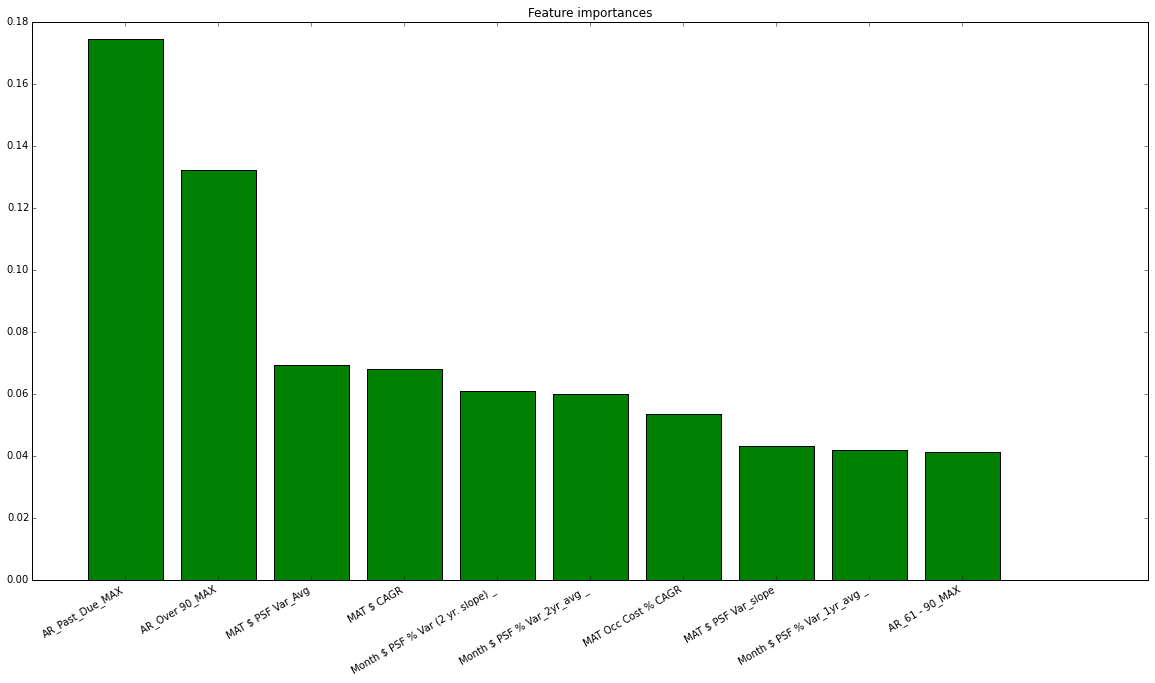

In [306]:
# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(rand_imp_range, rand_imp_featnums,
       color="g", align="center")
plt.xticks(rand_imp_range, rand_imp_feats, rotation=30, ha='right')
plt.show()




## K-means Clustering

In [268]:
# import kmeans libraries
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist

In [269]:
## create data for K-means clustering analysis
# k_list choooses categories I want to include in analysis
k_list = imp_feat_list
kmdata = INL_data[k_list].copy()  # make sure to make copy so it's more than reference
kmdata = kmdata.drop('Lease', axis=1)  # drop lease from log_data
kmdata = kmdata.dropna(axis=0)  # remove any blank values from dataframe

In [72]:
kmdata_X = kmdata.drop('Defaulted', axis=1)  # remove defaulted column from dataframe
kmdata_X = kmdata_X.values  # turn datatable into array
kmdata_y = kmdata['Defaulted']  

In [272]:
##### cluster data into K=1..10 clusters #####
# K, KM, centroids,D_k,cIdx,dist,avgWithinSS = kmeans.run_kmeans(X,10)

K = range(1,100)

  # scipy.cluster.vq.kmeans
KM = [kmeans(kmdata_X,k) for k in K] # apply kmeans 1 to 10
centroids = [cent for (cent,var) in KM]   # cluster centroids

D_k = [cdist(kmdata_X, cent, 'euclidean') for cent in centroids]

cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/kmdata_X.shape[0] for d in dist]

ValueError: object arrays are not supported

NameError: name 'avgWithinSS' is not defined

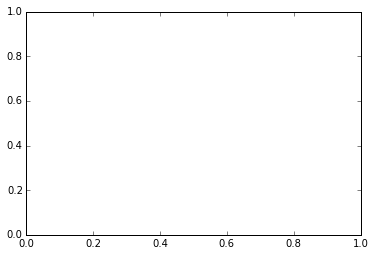

In [77]:
kIdx = 10
# plot elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Elbow for K-Means clustering')  

In [75]:
from sklearn.cluster import KMeans
km = KMeans(10, init='k-means++') # initialize
km.fit(kmdata_X)
c = km.predict(kmdata_X) # classify into three clusters

## Add cluster feature to data table

In [78]:
kmdata['cluster_num'] = c

# table below shows that defaulted tenants do not all get grouped together.
kmdata

,MAT $ CAGR,MAT $ (mo. slope),avg_occ_3yrs,MAT $ PSF Var_Avg,MAT $ PSF Var_slope,MAT Occ Cost % (slope),MAT Occ Cost % CAGR,MAT Occ Cost % CAGR to MAT $ Var,MAT Occ Cost %_Avg_Var _2013,MAT Occ Cost %_1yr_slope _,...,Holiday Month % Var _2013,Lease Term (mo.),AR_Past_Due_MAX,AR_% of Billings Owed_MAX,AR_61 - 90_MAX,AR_Over 90_MAX,AR_2monthover_MAX,National Tenant Flag-Calc,Defaulted,cluster_num
0,0.361141,5320.750000,0.385854,0.375510,0.211976,0.076509,0.572048,-0.210908,0.142591,-0.001817,...,-0.032776,12.033333,18709.21,2.208017,9382.91,852.99,1,0,1,6
3,0.003138,233.369583,0.307303,0.020201,-0.055179,0.063030,0.159839,-0.156701,0.094094,0.002508,...,-0.302160,41.533333,21098.70,1.098107,0.00,1884.99,1,0,1,5
4,-0.042795,-4272.468333,0.193986,-0.009102,-0.061479,-0.017836,-0.102595,0.059800,-0.034183,-0.004741,...,-0.170124,10.100000,-18100.27,0.000000,6451.03,17779.87,1,0,1,6
15,-0.007132,-909.045833,0.314015,-0.091493,0.136485,-0.025841,-0.062882,0.055751,-0.070661,-0.005619,...,-0.090383,3.733333,4935.36,0.328955,0.00,0.00,0,0,1,6
16,0.046818,4728.415833,0.352594,-0.069668,0.219157,-0.011355,0.024337,0.022481,-0.069336,-0.001520,...,0.002041,69.833333,7449.47,0.286865,-1252.84,0.00,0,0,1,6
17,0.027297,4218.025000,0.212426,-0.038370,0.111655,-0.061689,-0.160095,0.187392,-0.390789,-0.004936,...,-0.025595,24.700000,7645.24,0.167652,-3256.98,-17115.98,0,0,1,6
20,0.024471,2965.316667,0.300404,0.007333,0.010960,-0.005328,0.012690,0.011781,-0.061151,0.002252,...,-0.059058,63.600000,9164.52,0.341235,0.00,212.22,1,0,1,6
21,-0.022834,-3621.774167,0.275015,-0.075788,0.097619,-0.103406,-0.256893,0.234060,-0.478744,-0.008009,...,0.207337,6.133333,60961.49,1.642417,0.00,18065.90,1,0,1,5
22,-0.065178,-3943.577083,0.338985,-0.102406,0.014634,0.040100,0.011982,-0.077160,0.091002,0.002118,...,-0.184678,82.133333,45289.56,0.000000,719.00,30187.14,1,0,1,5
24,-0.023452,-2401.275417,0.113829,7.665126,-11.516648,0.010218,0.038614,-0.062066,-0.028466,0.000266,...,-0.055320,14.933333,30678.33,3.196039,959.89,10453.33,1,0,1,5


In [131]:
# kmdata[kmdata['cluster_num'] == 0]

## Support Vector Machines

In [133]:
from sklearn import svm

In [134]:
## create data for K-means clustering analysis
# k_list choooses categories I want to include in analysis
svm_list = imp_feat_list
svmdata = INL_data[svm_list].copy()  # make sure to make copy so it's more than reference
svmdata = svmdata.drop('Lease', axis=1)  # drop lease from log_data
svmdata = svmdata.dropna(axis=0)  # remove any blank values from dataframe

In [135]:
outliers = svmdata[svmdata['Defaulted'] == 1]
inliers = svmdata[svmdata['Defaulted'] == 0]

In [136]:
# inlier data
inlier_svmdata_X = inliers.drop('Defaulted', axis=1)  # remove defaulted column from dataframe
inlier_svmdata_X = inlier_svmdata_X.values  # turn datatable into array
inlier_svmdata_y = inliers['Defaulted']  

In [137]:
# inlier data
outlier_svmdata_X = outliers.drop('Defaulted', axis=1)  # remove defaulted column from dataframe
outlier_svmdata_X = outlier_svmdata_X.values  # turn datatable into array
outlier_svmdata_y = outliers['Defaulted']  

In [138]:
clf = svm.OneClassSVM(nu=0.5, kernel="rbf")
clf.fit(inlier_svmdata_X)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.0, kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [139]:
# cross_val_score(clf, svmdata_X, kmdata_y)

In [140]:
svm_pred_y = clf.predict(inlier_svmdata_X)

In [141]:
clf.get_params()

{'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'gamma': 0.0,
 'kernel': 'rbf',
 'max_iter': -1,
 'nu': 0.5,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [142]:
list(zip(inlier_svmdata_y, svm_pred_y))

[(0, 1.0),
 (0, 1.0),
 (0, -1.0),
 (0, -1.0),
 (0, 1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1

## PCA - Dimension Reduction

In [307]:
from sklearn.decomposition import PCA

In [308]:
pca_list = imp_feat_list
pca_data = INL_data[pca_list].copy()  # make sure to make copy so it's more than reference
pca_data = pca_data.drop('Lease', axis=1)
pca_data = pca_data.dropna(axis=0)
pca_data_X = pca_data.drop('Defaulted', axis=1)

pca_X = pca_data_X.values
pca_y = pca_data['Defaulted']


In [309]:
# create the model and fit the data
pca = PCA(n_components=2)
X_r = pca.fit(pca_X).transform(pca_X)

In [310]:
# first component explains how much data is available (not lost)
pca.explained_variance_ratio_  

array([ 0.643824  ,  0.29381758])

/Users/brianporter/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


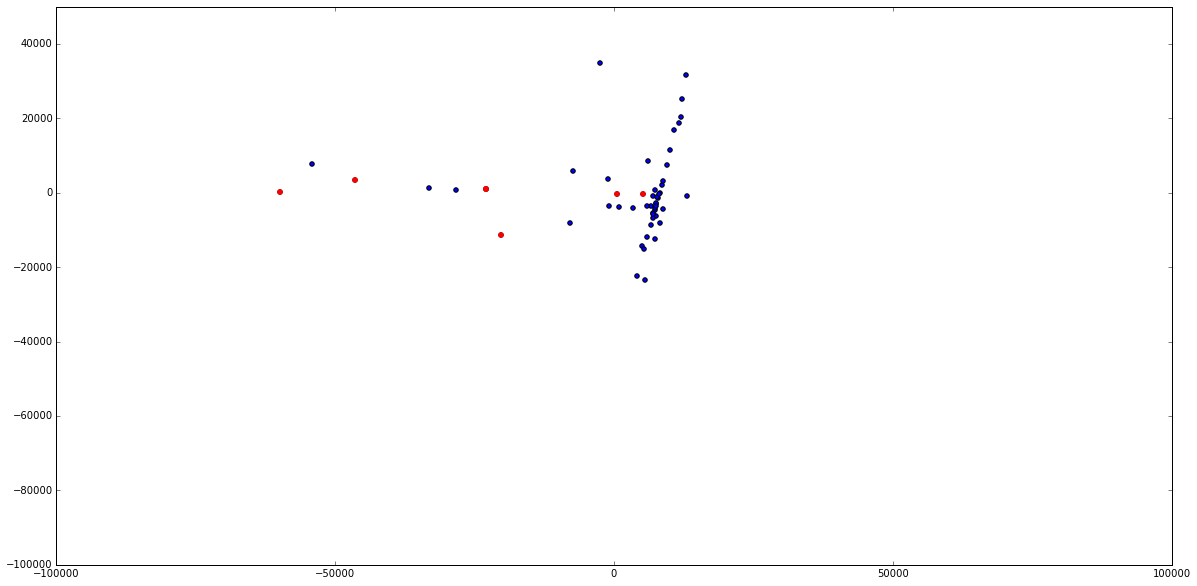

In [311]:
plt.figure(figsize=(20,10))
plt.xlim(-100000, 100000)
plt.ylim(-100000, 50000)
plt.scatter(X_r[:,0], X_r[:,1])


default_tens = []
for i, x in enumerate(pca_y):  #returns index in addition to the value of the index
    if x == 1:
#         print(X_r[i, 0], X_r[i, 1], pca_X[i])
        plt.scatter(X_r[i, 0], X_r[i, 1], color='r')
 

## LDA & QDA - Dimension Reduction

In [57]:
from sklearn.lda import LDA  # Linear Discriminant Analysis
from sklearn.qda import QDA  # Quadratic Discriminant Analysis

In [64]:
# create the model and fit the data
lda = LDA(n_components=3)
X_r2 = lda.fit(pca_X, pca_y).transform(pca_X)

//anaconda/lib/python3.4/site-packages/sklearn/lda.py:371: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [65]:
print(X_r2)

[[ 1.8792045 ]
 [ 1.02647661]
 [ 1.21164678]
 ..., 
 [-0.34844715]
 [-0.23930798]
 [-0.51632652]]


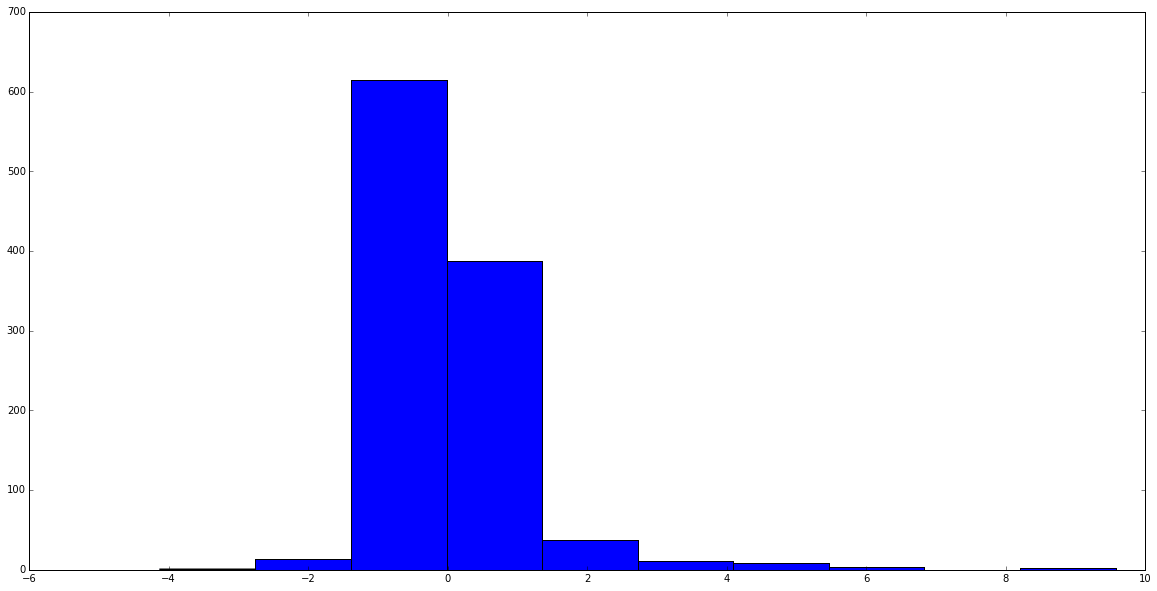

In [151]:
plt.figure(figsize=(20,10))
# plt.xlim(-100000, 100000)
# plt.ylim(-100000, 100000)
plt.hist(X_r2)
plt.show()


# for i, x in enumerate(pca_y):  #returns index in addition to the value of the index
#     if x == 1:
#         print(X_r2[i, 0], pca_X[i])
#         plt.hist(X_r2[i, 0], color='r')


In [61]:
# create the model and fit the data
qda = QDA()
X_r3 = qda.fit(pca_X, pca_y).predict(pca_X)

//anaconda/lib/python3.4/site-packages/sklearn/qda.py:133: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [84]:
# R^2 correlation between data features
# pca_data.corr()